In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from fitellipse import *

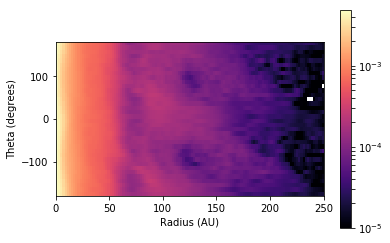

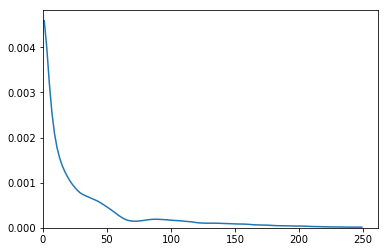

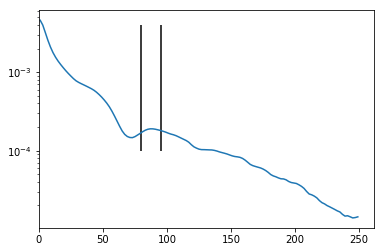

In [93]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/Elias27_tapered.image.fits',
                          'distance':116,
                          'incl' : 57.2,
                          'PA' : 118.4,
                          'offsetx' : .31*.003,
                          'offsety' : -1.6*.003,
                          'size': 4,
                          'gamma': 0.5
                         }

cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
maxrad = 250
radialbins = 1+2*np.arange(125)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
#           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = 0.4))\
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.LogNorm(vmin = 1.e-5))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.vlines(80, 1.e-4, .004)
plt.vlines(95,1.e-4,.004)
plt.xlim(xmin = 0)
plt.show()



/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -6.469e-03 arcsec, delta_y = -7.621e-03 arcsec
The MLE semi-major axis is r = 0.594 arcsec
The MLE inclination is i = 55.909 degrees
The MLE position angle is PA = 118.715 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.574e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


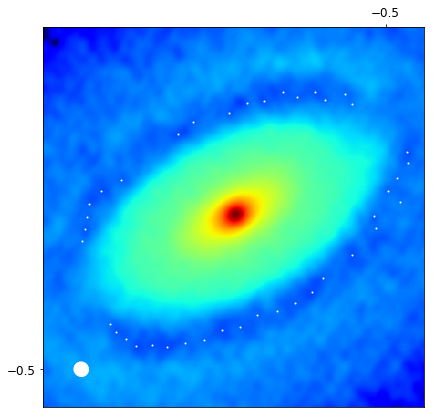

In [117]:


# Extract the gap that's at ~70 AU
xcoords1, ycoords1 = cont.extract_ring(65,75,
                                       tbins = np.concatenate((-177+6*np.arange(11),  -88+6*np.arange(27),123+6*np.arange(10))),
                                                                     extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 1.25, cmap = 'jet')

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     70/116.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)


In [119]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -1<cosi<1 and 0 < par < np.pi and -12<logvar<-6:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 100
nthreads = 8
nsteps = 1000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

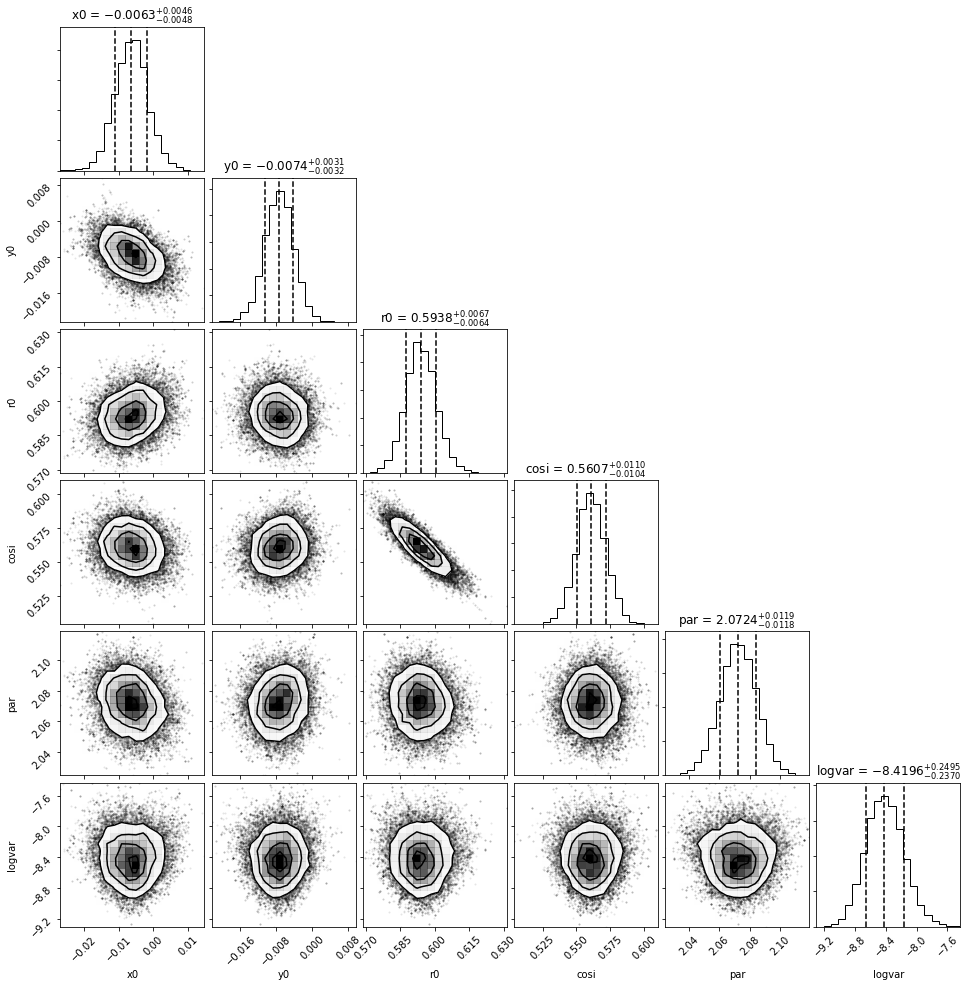

The x offset is delta_x = -6.26e-03 arcsec (+4.6e-03, -4.8e-03)
The y offset is delta_y = -7.40e-03 arcsec (+3.1e-03, -3.2e-03)
The median semi-major axis is r = 0.5938 arcsec (+0.0067, -0.0064) 
or 68.88 AU (+0.36, -0.37)
The incl is i = 55.90 deg (+0.72, -0.77)
The median position angle is PA = 118.74 deg (+0.68, -0.68)
The median log-variance in the pixel offsets from the true ellipse is -8.420e+00


In [120]:


plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)


In [135]:

maxrad = 250
radialbins = 0.5+np.arange(0, maxrad)
#make some preliminary plots
newcont = Continuum(disk['filename'], -0.0063,-0.0074, 118.7, 55.9,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [86, 223, 233]
min [70, 223, 231, 244]


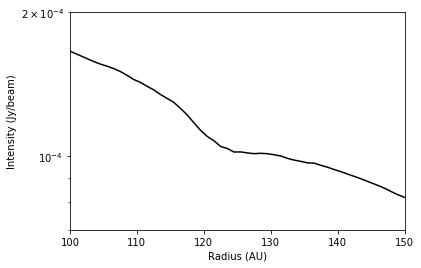

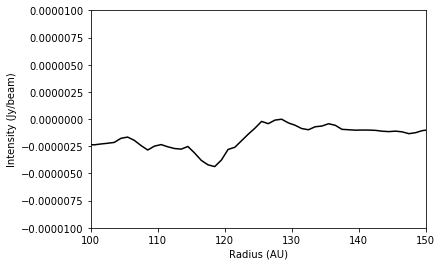

[ -2.36868225e-06  -2.29055863e-06  -2.22521952e-06  -2.14586273e-06
  -1.76930831e-06  -1.65576912e-06  -1.96052637e-06  -2.43546995e-06
  -2.84524027e-06  -2.48848490e-06  -2.34616544e-06  -2.55072504e-06
  -2.70761031e-06  -2.76478447e-06  -2.52093279e-06  -3.12388915e-06
  -3.80040099e-06  -4.20777796e-06  -4.37085577e-06  -3.76791007e-06
  -2.79203995e-06  -2.59499205e-06  -1.98850549e-06  -1.39449070e-06
  -8.42017657e-07  -2.15909649e-07  -4.20695366e-07  -9.59707518e-08
  -1.20949249e-08  -3.51923229e-07  -5.65732584e-07  -8.72771377e-07
  -9.81402492e-07  -7.06141794e-07  -6.43730935e-07  -4.28527500e-07
  -5.70930250e-07  -9.42943976e-07  -9.77411194e-07  -1.01926181e-06
  -1.00736705e-06  -1.01250568e-06  -1.03729807e-06  -1.11475611e-06
  -1.15219556e-06  -1.10900047e-06  -1.17546472e-06  -1.34170415e-06
  -1.25120405e-06  -1.06320889e-06]


(array([ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85, 128, 167, 223, 231, 232, 239, 244, 245, 246, 247, 248, 249]),)

In [153]:
plt.semilogy(radialbins, newsurfbrightness, color = 'black')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 100, xmax = 150)
plt.ylim(ymin = 7.e-5, ymax = 2.e-4)
plt.show()

plt.plot(radialbins, np.gradient(newsurfbrightness), color = 'black')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 100, xmax = 150)
plt.ylim(ymin = -1.e-5, ymax = 1.e-5)
plt.show()

print(np.gradient(newsurfbrightness)[100:150])
np.where(np.gradient(newsurfbrightness)>-2.e-8)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


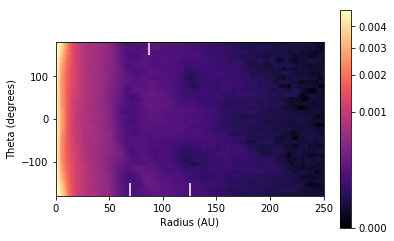

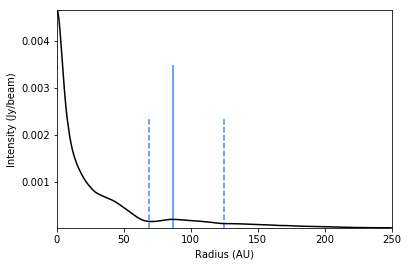

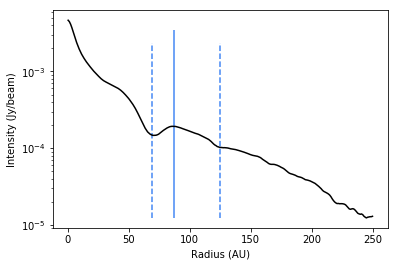

(0, 250)

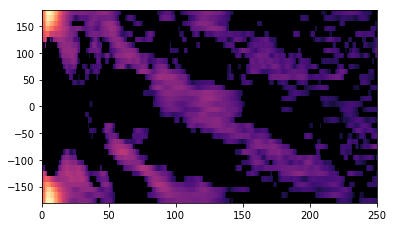

In [157]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
gaps = np.array([68.9, 125])
rings = np.array([87])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(7135, 4000)


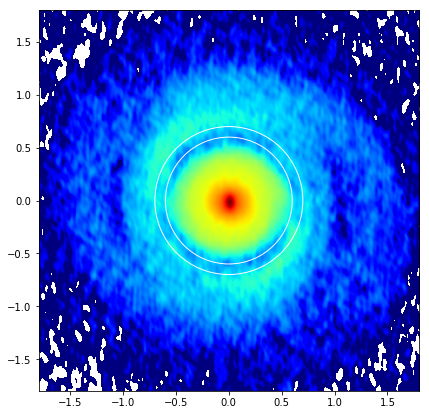

In [129]:
plt.figure(figsize = (7,7))

circularized = newcont.circularize()

print(circularized.shape)

LBmap = plt.subplot(111, aspect = 'equal', adjustable = 'box')
plt.imshow(circularized[2968:4168,1400:2600], origin = 'lower', 
           norm = col.LogNorm(vmin = 3.e-5), cmap = 'jet', 
           extent = [-600*.003, 600*.003, -600*.003, 600*.003])

ring = Ellipse(xy=(0, 0), width=1.2, height=1.2, angle=0, facecolor='none', edgecolor = 'white')
LBmap.add_artist(ring)

ring2 = Ellipse(xy=(0, 0), width=1.4, height=1.4, angle=0, facecolor='none', edgecolor = 'white')
LBmap.add_artist(ring2)
